<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session15/s15_qualifier/EVA4S15_loss_algo_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 15: Depth Map model

### Analysing how different loss functions calculate loss for two images.

In this notebook following four loss functions are analysed:
- nn.BCEwithLogitsLoss
- nn.SmoothL1Loss
- nn.MSELoss
- kornia.losses.SSIM

Samples used for analysis are:
- Mask images are in binary form: 0 or 255.
- Depth images are in gray scale: 0 to 255 scale

As we will be using loss functions for calculating loss for GT-Mask and Predicted-Mask as well as for GT-Depth and Predicted-Depth, so examples are taken from the mask and depth samples. 

Following cases are consider for analysing the result of various loss functions:

## MASK IMAGES - BINARY
#### Examples-1: Similar images
#### Example-2: Slight Spatial variance of an same object in the images
#### Example-3: Major spatial variance of the same object in the images
#### Example-4: Silghtly different objects are placed almost at similar spatial positions
#### Examples-5: Two different objects are placed in the images

## DEPTH IMAGES - GRAY SCALE
#### Example-1: Similar images
#### Example-2: Different backgrounds but same forground object at same spatial position
#### Example-3: Similar background but different foreground
#### Example-4: Different background and different foreground objects

In [0]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# switch to root working directory
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier


In [0]:
# for Structural Similarity Index between two images
import pkgutil
if pkgutil.find_loader("kornia") is None:
  !pip install kornia

In [0]:
# Load standard packages
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import zipfile
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# initialize dataset locations
root_dataset = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset"

bg_zipfile_name = f'{root_dataset}/bg_images.zip'                    # background images location
fg_bg_zipfile_name = f'{root_dataset}/fg_bg_images.zip'              # forground-background overlay images location
fg_bg_mask_zipfile_name = f'{root_dataset}/fg_bg_mask_images_c1.zip'    # forground-background overlay mask images location
fg_bg_depth_zipfile_name = f'{root_dataset}/fg_bg_depth_images.zip'  # forground-background depth map images location

In [0]:
# dataset means and stds
bg_means, bg_stds = np.round(np.array([142.3604, 129.986, 115.9921])/255., 3) , np.round(np.array([65.6258, 64.9718, 65.5989])/255., 3)
fg_bg_means, fg_bg_stds =  np.round(np.array([142.8615, 130.0039, 117.2206])/255., 3) ,	 np.round(np.array([66.4145, 65.5184, 66.0169])/255., 3)
mask_means, mask_stds =  np.round(np.array([23.2702])/255., 3) ,  np.round(np.array([72.9364])/255., 3)
depth_means, depth_stds =  np.round(np.array([147.4633])/255., 3) ,  np.round(np.array([72.0034])/255., 3)

ds_means_stds = {
    "bg_means": bg_means,
    "bg_stds": bg_stds,
    "fg_bg_means": fg_bg_means,
    "fg_bg_stds": fg_bg_stds,
    "mask_means": mask_means,
    "mask_stds": mask_stds,
    "depth_means": depth_means,
    "depth_stds": depth_stds,
}

ds_means_stds

{'bg_means': array([0.558, 0.51 , 0.455]),
 'bg_stds': array([0.257, 0.255, 0.257]),
 'depth_means': array([0.578]),
 'depth_stds': array([0.282]),
 'fg_bg_means': array([0.56, 0.51, 0.46]),
 'fg_bg_stds': array([0.26 , 0.257, 0.259]),
 'mask_means': array([0.091]),
 'mask_stds': array([0.286])}

In [0]:
# get datasets zip resources
zf_ds_dict = {"bg": zipfile.ZipFile(bg_zipfile_name, 'r'),
         "fgbg": zipfile.ZipFile(fg_bg_zipfile_name, 'r'),
         "mask": zipfile.ZipFile(fg_bg_mask_zipfile_name, 'r'),
         "depth": zipfile.ZipFile(fg_bg_depth_zipfile_name, 'r')}

In [0]:
# fxn to close the zip file resource
def close_zip_resources(zf_dict):
    for k, v in zf_dict.items():
      v.close()

In [0]:
# release zip resources as all the image data are already loaded and ready for use
#close_zip_resources(zf_ds_dict)

### Compare various Image comparision algorithms

In [0]:
def read_image_file(zf, filename):
          data = zf.read(filename)
          dataEnc = BytesIO(data)
          img = Image.open(dataEnc)
          return img

In [0]:
from torchvision.transforms import transforms
import kornia

def compare_images(algo, im1, im2):
    trans = transforms.Compose([                        
                              transforms.ToTensor()         
                              ])

    im1 = trans(im1).unsqueeze(0)
    im2 = trans(im2).unsqueeze(0)
    result = algo(im1,im2)
    return np.round(result.item(),4)

def compare_images_bce_sigmoid(im1, im2):
    trans = transforms.Compose([                        
                              transforms.ToTensor(),
                              transforms.Normalize(mask_means, mask_stds)                
                              ])
    im1 = trans(im1)
    im1 = nn.Sigmoid()(im1)

    im2 = trans(im2)
    im2 = nn.Sigmoid()(im2)

    im1 = im1.unsqueeze(0)
    im2 = im1.unsqueeze(0)
    result = nn.BCELoss()(im1,im2)
    return result.item()

def compare_algorithms(im1, im2):
    results = {}
    algo = kornia.losses.SSIM(3, reduction='mean')
    res = compare_images(algo, im1,im2)
    results["SSIM"] = res
    print("SSIM: ", type(res))
    
    algo = nn.SmoothL1Loss()
    index = compare_images(algo, im1,im2)
    res = compare_images(algo, im1,im2)
    results["SmoothL1Loss"] = res
    print("SmoothL1Loss: ", type(res))
    
    algo = nn.MSELoss(reduction='sum')
    res = compare_images(algo, im1,im2)
    results["MSELoss"] = res
    print("MSELoss: ", type(res))
    
    algo = nn.BCEWithLogitsLoss()
    res = compare_images(algo, im1,im2)
    results["BCEWithLogitsLoss"] = res
    print("BCEWithLogitsLoss: ", type(res))
    
    algo = nn.BCELoss()
    res = compare_images(algo, im1,im2) # working without normalized values
    results["BCELoss"] = res
    print("BCELoss: ", type(res))
    
    return results

def show_save(im1, im2, filename):
    fig = plt.figure(figsize=(8,8)) 
    #fig.suptitle('Same Images', fontsize=16)

    plt.subplot(1,2, 1),plt.imshow(im1.convert('LA'))
    plt.axis('off')

    plt.subplot(1,2, 2),plt.imshow(im2.convert('LA'))
    plt.axis('off')

    plt.savefig(filename)
    plt.show()

# MASK IMAGES - BINARY

### Examples-1: Similar images

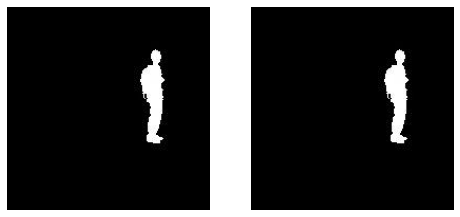

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.0, 'SmoothL1Loss': 0.0, 'MSELoss': 0.0, 'BCEWithLogitsLoss': 0.6816, 'BCELoss': 0.0034}


In [0]:
im1 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Example-2: Slight Spatial variance of an same object in the images

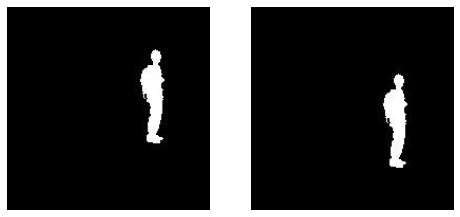

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.0314, 'SmoothL1Loss': 0.0131, 'MSELoss': 964.3807, 'BCEWithLogitsLoss': 0.6947, 'BCELoss': 1.8151}


In [0]:
im1 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['mask'], "fg011_bg022_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Example-3: Major spatial variance of the same object in the images

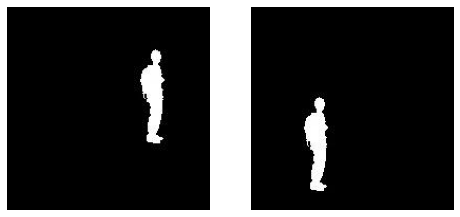

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.0549, 'SmoothL1Loss': 0.0312, 'MSELoss': 2297.314, 'BCEWithLogitsLoss': 0.713, 'BCELoss': 5.0698}


In [0]:
im1 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_11.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Example-4: Silghtly different objects are placed almost at similar spatial positions

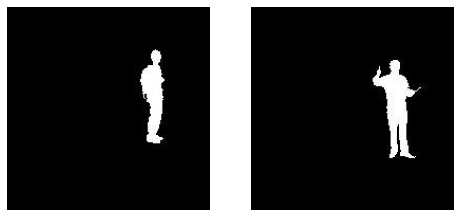

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.031, 'SmoothL1Loss': 0.0117, 'MSELoss': 862.0144, 'BCEWithLogitsLoss': 0.6872, 'BCELoss': 1.4989}


In [0]:
im1 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['mask'], "fg002_bg021_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Examples-5: Two different objects are placed in the images

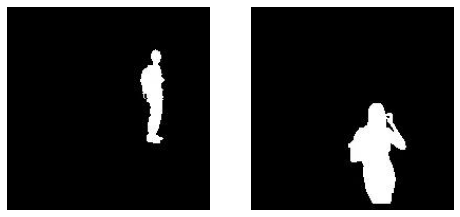

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.0735, 'SmoothL1Loss': 0.0499, 'MSELoss': 3679.5933, 'BCEWithLogitsLoss': 0.7092, 'BCELoss': 8.8211}


In [0]:
im1 = read_image_file(zf_ds_dict['mask'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['mask'], "fg022_bg021_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

# DEPTH IMAGES - GRAY SCALE

### Example-1: Similar images

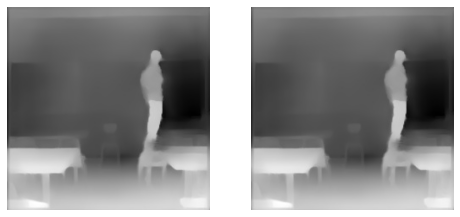

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.0, 'SmoothL1Loss': 0.0, 'MSELoss': 0.0, 'BCEWithLogitsLoss': 0.7013, 'BCELoss': 0.5932}


In [0]:
im1 = read_image_file(zf_ds_dict['depth'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['depth'], "fg011_bg021_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Example-2: Different backgrounds but same forground object at same spatial position

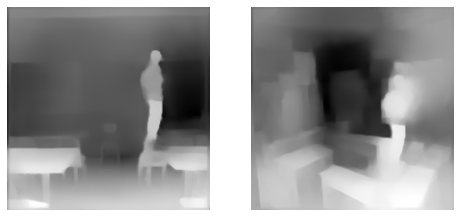

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.1241, 'SmoothL1Loss': 0.0259, 'MSELoss': 2980.2856, 'BCEWithLogitsLoss': 0.6843, 'BCELoss': 0.7048}


In [0]:
im1 = read_image_file(zf_ds_dict['depth'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['depth'], "fg011_bg022_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Example-3: Similar background but different foreground

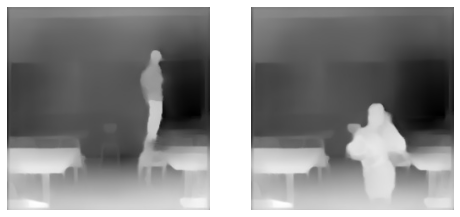

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.0402, 'SmoothL1Loss': 0.0114, 'MSELoss': 1311.8331, 'BCEWithLogitsLoss': 0.7048, 'BCELoss': 0.6177}


In [0]:
im1 = read_image_file(zf_ds_dict['depth'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['depth'], "fg022_bg021_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

### Example-4: Different background and different foreground objects

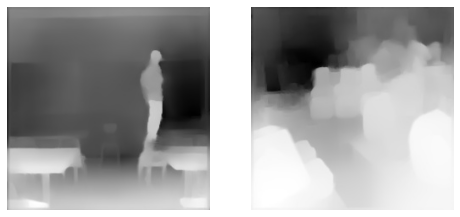

SSIM:  <class 'numpy.float64'>
SmoothL1Loss:  <class 'numpy.float64'>
MSELoss:  <class 'numpy.float64'>
BCEWithLogitsLoss:  <class 'numpy.float64'>
BCELoss:  <class 'numpy.float64'>

Results: {'SSIM': 0.1548, 'SmoothL1Loss': 0.0654, 'MSELoss': 7529.5537, 'BCEWithLogitsLoss': 0.6275, 'BCELoss': 0.7651}


In [0]:
im1 = read_image_file(zf_ds_dict['depth'], "fg011_bg021_01.jpg")
im2 = read_image_file(zf_ds_dict['depth'], "fg022_bg011_01.jpg")

show_save(im1,im2,filename="compare_image1.jpg")
results = compare_algorithms(im1,im2)
print(f'\nResults: {results}')

In [0]:
# release zip resources as all the image data are already loaded and ready for use
close_zip_resources(zf_ds_dict)